In [1]:
import numpy as np
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from train import train_model, train_loss, train_accuracy, val_loss, val_accuracy
from torchsummary import summary
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 32


dataset = torch.load('dataset.pt')
lengths = [
    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]

trainset, valset, testset = random_split(dataset, lengths)
image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  

In [2]:
class MultiCNN(nn.Module):
    def __init__(self):
        super(MultiCNN, self).__init__()
        self.fc1 = nn.Linear(6144, 256)
        self.fc2 = nn.Linear(256, 2)
        self.fc3 = nn.Linear(10, 2)
        resnet = models.resnet50(pretrained=True).to(device) 
        self.new_resnet1 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet2 = nn.Sequential(*list(resnet.children())[:-1])
        self.new_resnet3 = nn.Sequential(*list(resnet.children())[:-1])
        self.drop = nn.Dropout(p=0.5)
        
    def forward(self, x_slices):

        x1 = x_slices[0]
        x1 = self.new_resnet1(x1)
        x1 = x1.view(-1, 2048)

        x2 = x_slices[1]
        x2 = self.new_resnet2(x2)
        x2 = x2.view(-1, 2048)

        x3 = x_slices[2]
        x3 = self.new_resnet3(x3)
        x3 = x3.view(-1, 2048)

        out = torch.cat((x1, x2, x3), dim=-1)
        out = F.relu(self.drop(self.fc1(out)))
        out = F.relu(self.fc2(out))

        return out

Epoch 0/24
----------------------------------------------------------------------------------------------------



train Loss: 0.6591 Acc: 0.5847



val Loss: 0.6063 Acc: 0.6356
Epoch 1/24
----------------------------------------------------------------------------------------------------



train Loss: 0.5296 Acc: 0.5900



val Loss: 0.5853 Acc: 0.6356
Epoch 2/24
----------------------------------------------------------------------------------------------------



train Loss: 0.4396 Acc: 0.7405



val Loss: 0.7673 Acc: 0.7119
Epoch 3/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2789 Acc: 0.8867



val Loss: 0.5496 Acc: 0.7881
Epoch 4/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2124 Acc: 0.9258



val Loss: 0.7326 Acc: 0.8305
Epoch 5/24
----------------------------------------------------------------------------------------------------



train Loss: 0.2167 Acc: 0.9269



val Loss: 0.7145 Acc: 0.7542
Epoch 6/24
----------------------------------------------------------------------------------------------------



train Loss: 0.1179 Acc: 0.9555



val Loss: 0.7278 Acc: 0.7966
Epoch 7/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0760 Acc: 0.9703



val Loss: 0.6680 Acc: 0.8475
Epoch 8/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0472 Acc: 0.9905



val Loss: 0.6173 Acc: 0.8390
Epoch 9/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0212 Acc: 0.9989



val Loss: 0.5976 Acc: 0.8390
Epoch 10/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0216 Acc: 0.9958



val Loss: 0.6241 Acc: 0.8559
Epoch 11/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0185 Acc: 0.9979



val Loss: 0.5680 Acc: 0.8559
Epoch 12/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0143 Acc: 1.0000



val Loss: 0.5686 Acc: 0.8644
Epoch 13/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0094 Acc: 1.0000



val Loss: 0.7107 Acc: 0.8559
Epoch 14/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0118 Acc: 0.9989



val Loss: 0.6474 Acc: 0.8559
Epoch 15/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0126 Acc: 0.9979



val Loss: 0.6402 Acc: 0.8390
Epoch 16/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0123 Acc: 0.9979



val Loss: 0.6364 Acc: 0.8475
Epoch 17/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0098 Acc: 1.0000



val Loss: 0.7500 Acc: 0.8390
Epoch 18/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0102 Acc: 1.0000



val Loss: 0.6936 Acc: 0.8305
Epoch 19/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0148 Acc: 0.9979



val Loss: 0.5924 Acc: 0.8559
Epoch 20/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0118 Acc: 0.9989



val Loss: 0.6372 Acc: 0.8559
Epoch 21/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0132 Acc: 0.9968



val Loss: 0.6761 Acc: 0.8390
Epoch 22/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0123 Acc: 0.9989



val Loss: 0.6868 Acc: 0.8644
Epoch 23/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0096 Acc: 0.9989



val Loss: 0.5615 Acc: 0.8559
Epoch 24/24
----------------------------------------------------------------------------------------------------



train Loss: 0.0119 Acc: 0.9989



val Loss: 0.6410 Acc: 0.8475
Training complete in 1m 32s
Best val Acc: 0.864407


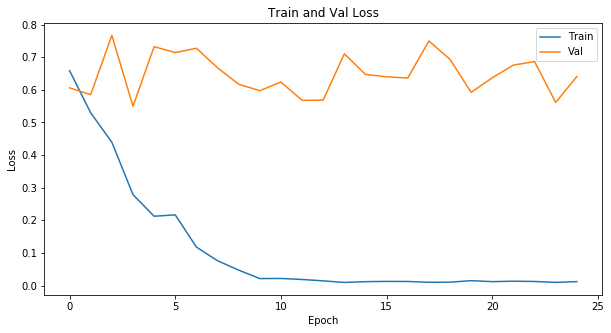

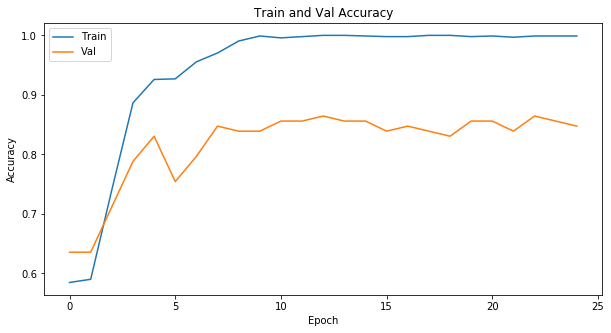

In [3]:
model = MultiCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=25, batch_size = batch_size)